# TRABAJO Parte 2: AIA_2022-2023

**Alumna 1: Vidal Fernández, Andrea**

**Alumna 2: García Barragán, Lidia**

# Transfer Learning con CNNs - Dataset: Flowers

La idea de este trabajo es familiarizarnos con dos situaciones muy habituales en la actividad real de un "Machine Learning Engineer":

1.   En primer lugar, con una de las técnicas más potentes asociadas con las redes neuronales: el **Transfer Learning**. Dado que las redes neuronales, para resolver un problema, capturan en su estructura de capas y pesos una representación jerárquica del problema.
Entonces..., ¿por qué no aprovechar ese conocimiento obtenido, para resolver otro problema diferente?

2.  En segundo lugar, con la **busqueda de información sobre conceptos nuevos**. En este caso, los dos primeros modelos a implementar los hemos trabajado en clase. No así el Transfer Learning, y por tanto, deberéis buscar vosotros mismos cómo hacer lo que se pide para el Modelo 3. Consultar en blogs, web y tutoriales es algo común en el día a día de alguien que quiere profundizar en el ML y, para ello, existen infinidad de fuentes. A modo de ejemplo, una fuente para profundizar en el Transfer Learning con redes convolucionales es: https://www.learndatasci.com/tutorials/hands-on-transfer-learning-keras/

En este trabajo vamos intentar resolver un problema de clasificación sobre un dataset propuesto por Tensorflow en 2019 conocido como "flowers". Este conjunto está formado por 3670 imágenes de flores pertenecientes a 5 clases diferentes. Para ello implementaremos 3 modelos:

*   Modelo 1: implementación de una CNN básica.
*   Modelo 2: es una evolución del modelo anterior, aplicando técnicas que reduzcan el overfitting.
*   Modelo 3: rompemos la barrera de tener que seguir complicando nuestro modelo y se pide aplicar transfer learning utilizando un pre-trained model.





# a) Carga de datos

In [ ]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd

import pathlib
import os
import glob
import shutil
tf.__version__

'2.12.0'

Descargamos el dataset que pone a nuestra disposición Tensorflow.

In [ ]:
_URL = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

zip_file = tf.keras.utils.get_file(origin = _URL,
                                   fname = "flower_photos.tgz",
                                   extract = True)

base_dir = os.path.join(os.path.dirname(zip_file), 'flower_photos')

228813984/228813984 [==============================] - 2s 0us/step


Tras completar la descarga, debemos tener la siguiente estructura de directorios:

<pre style="font-size: 10.0pt; font-family: Arial; line-height: 2; letter-spacing: 1.0pt;" >
<b>flower_photos</b>
|__ <b>daisy</b>
|__ <b>dandelion</b>
|__ <b>roses</b>
|__ <b>sunflowers</b>
|__ <b>tulips</b>
</pre>

Desgraciadamente, para este dataset, Tensorflow no nos proporciona la estructura de directorios necesaria de train y de validación. Por lo que debemos proceder del siguiente modo:

* Crear una carpeta `train` y de `val`, cada una de ellas debe contener a su vez, cinco subdirectorios: uno para cada clase de flor.
* Moveremos las imágenes de las carpetas originales a estas nuevas carpetas. De modo que el 80% de las imágenes vayan al conjunto de train y el 20% restante al de validación.
* La estructura final de directorios debe ser la siguiente:

<pre style="font-size: 10.0pt; font-family: Arial; line-height: 2; letter-spacing: 1.0pt;" >
<b>flower_photos</b>
|__ <b>train</b>
    |______ <b>daisy</b>: [12.jpg, 28.jpg, 31.jpg ....]
    |______ <b>dandelion</b>: [41.jpg, 22.jpg, 35.jpg ....]
    |______ <b>roses</b>: [121.jpg, 92.jpg, 38.jpg ....]
    |______ <b>sunflowers</b>: [93.jpg, 23.jpg, 83.jpg ....]
    |______ <b>tulips</b>: [109.jpg, 267.jpg, 93.jpg ....]
 |__ <b>val</b>
    |______ <b>daisy</b>: [507.jpg, 508.jpg, 509.jpg ....]
    |______ <b>dandelion</b>: [719.jpg, 720.jpg, 721.jpg ....]
    |______ <b>roses</b>: [514.jpg, 515.jpg, 516.jpg ....]
    |______ <b>sunflowers</b>: [560.jpg, 561.jpg, 562.jpg .....]
    |______ <b>tulips</b>: [640.jpg, 641.jpg, 642.jpg ....]
</pre>

Creamos una lista con el nombre de las 5 clases. En castellano sería: margaritas, diente de león, rosas, girasoles y tulipanes.

In [ ]:
classes = ['roses', 'daisy', 'dandelion', 'sunflowers', 'tulips']

Creemos la estructura de directorios necesaria:

In [ ]:
SPLIT_RATIO = 0.8

for cl in classes:
    # path de las imagenes de la clase cl
    img_path = os.path.join(base_dir, cl)

    # obtenemos la lista de todas las imagenes
    images = glob.glob(img_path + '/*.jpg')
    print("{}: {} Imagenes".format(cl, len(images)))

    # determinamos cuantas imagenes son el 80%
    num_train = int(round(len(images) * SPLIT_RATIO))

    # separamos las imagenes en dos listas
    train, val = images[:num_train], images[num_train:]

    # creamos la carpeta de train/clase y val/clase
    if not os.path.exists(os.path.join(base_dir, 'train', cl)):
            os.makedirs(os.path.join(base_dir, 'train', cl))
    if not os.path.exists(os.path.join(base_dir, 'val', cl)):
            os.makedirs(os.path.join(base_dir, 'val', cl))

    # movemos las imagenes
    for t in train:
        shutil.move(t, os.path.join(base_dir, 'train', cl))
    for v in val:
        shutil.move(v, os.path.join(base_dir, 'val', cl))

roses: 641 Imagenes
daisy: 633 Imagenes
dandelion: 898 Imagenes
sunflowers: 699 Imagenes
tulips: 799 Imagenes


Preparamos variables con las rutas de los diferentes directorios:

In [ ]:
# Definimos las variables que contienen el path para los datos de train y validación
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

# Definimos las variables que contienen el path de los directorios de cada clase
daisy_dir = os.path.join(train_dir, 'daisy')
dandelion_dir = os.path.join(train_dir, 'dandelion')
roses_dir = os.path.join(train_dir, 'roses')
sunflowers_dir = os.path.join(train_dir, 'sunflowers')
tulips_dir = os.path.join(train_dir, 'tulips')

Muestre el nombre de dos ficheros cualquiera en alguna de esas rutas:

In [ ]:
# Mostramos la ruta de los directorios de las dos primeras clases

print("Directorio de fichero daisy:", daisy_dir)
print("Directorio de fichero dandelion:", dandelion_dir)

Directorio de fichero daisy: /root/.keras/datasets/flower_photos/train/daisy
Directorio de fichero dandelion: /root/.keras/datasets/flower_photos/train/dandelion


Es decir, la clase a la que pertenece cada imagen no viene dada por el nombre del fichero sino por el directorio en el que se encuentra almacenada.

Muestra el número de imágenes de train que tenemos de cada clase:

In [ ]:
# Para cada directorio perteneciente a cada clase mostramos el número de imágenes que contiene

directorios = [daisy_dir, dandelion_dir, roses_dir, sunflowers_dir, tulips_dir]
for dir in directorios:
  numero = os.listdir(dir)
  nombre = dir.split('/')[-1]
  print('training', nombre, ':', len(numero))

training daisy : 506
training dandelion : 718
training roses : 513
training sunflowers : 559
training tulips : 639


# b) Visualización del dataset

Muestra 3 imágenes de cada una de las clases, utilizando como título de la imagen, el shape del array de numpy asociado a cada imagen. Comprueba que las imágenes tienen diferentes shapes, por lo que más adelante tendremos que unificar su tamaño.

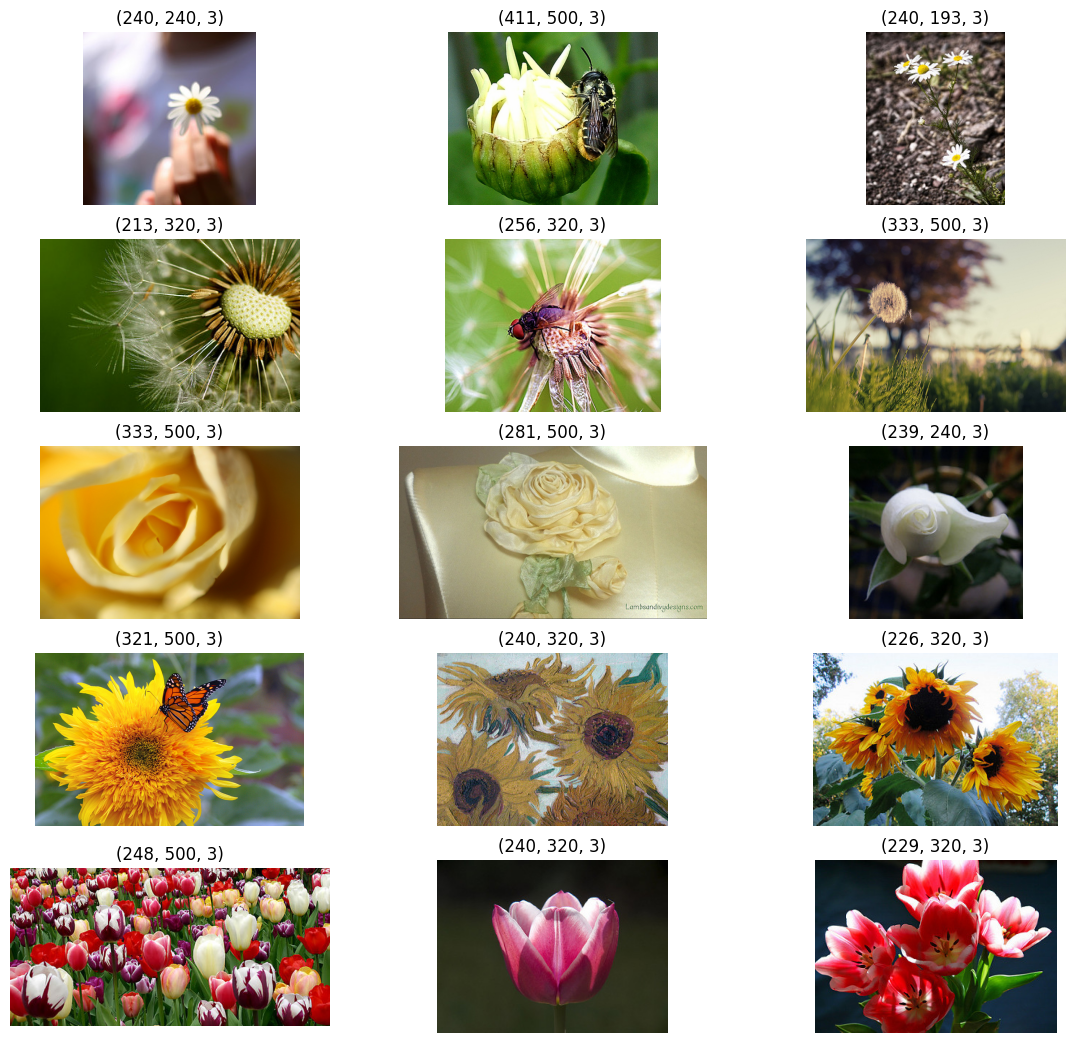

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Cogemos 3 imágenes de cada clase

daisy = [os.path.join(daisy_dir, fname) for fname in os.listdir(daisy_dir)[0:3] ]
dandelion = [os.path.join(dandelion_dir, fname) for fname in os.listdir(dandelion_dir)[0:3] ]
roses = [os.path.join(roses_dir, fname) for fname in os.listdir(roses_dir)[0:3] ]
sunflowers = [os.path.join(sunflowers_dir, fname) for fname in os.listdir(sunflowers_dir)[0:3] ]
tulips = [os.path.join(tulips_dir, fname) for fname in os.listdir(tulips_dir)[0:3] ]

plt.figure(figsize = (14, 13))

# Para cada clase mostramos las 3 imágenes seleccionadas anteriormente
# Definimos 5 filas, una para cada clase, y 3 columnas para cada una de las imágenes de dicha clase

for i, img_path in enumerate(daisy + dandelion + roses + sunflowers + tulips):
  sp = plt.subplot(5, 3, i + 1)
  sp.axis('Off')
  img = mpimg.imread(img_path)
  plt.title(img.shape)
  plt.imshow(img)

# c) Modelo 1: CNN básica (objetivo: accuracy_valid > 60%)


Implemente una red convolucional para resolver el problema de clasificación. Para ello se sugiere una CNN con 3 capas convolucionales + pooling con la siguiente estructura:

Bloque de procesamiento de imagen:
1.   32 kernels -> 64 kernels -> 96 kernels
2.   kernels de 3x3.
3.   Stride = 1 y padding = SI.
4.   Función de activación ReLU.
5.   Maxpooling de 2x2 con stride clásico de 2 pixeles.
6.   Igualamos el tamaño de todas las imágenes a 150 x 150.

Bloque de decisión:
7.   Capa densa de 512 neuronas.
8.   Capa densa de salida.

**Entrene un modelo con la estructura anterior de manera que obtenga un accuracy (sobre el conjunto de validación) > 60%.** Utilice el optimizador que considere más adecuado.

Sugerencias:
*   Recuerda que si no se realiza conversión a One-Hot de la etiqueta a predecir, debes utilizar como función de error `SparseCategoricalCrossentropy` (este es el procedimiento que hemos usado en clase).
*   Considera un learning rate en el entorno de 0.001.
*   En el caso de los generators utiliza `class_mode='sparse'`.
*   Puedes utilizar p.e. un `batch_size = 100`.




In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

In [ ]:
# Definimos el modelo tal y como nos lo han planteado en el enunciado
# Mostramos la dimensión de entrada y salida para cada capa

model = Sequential([

    # dimension = (150, 150, 3)
    Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same', activation = 'relu', input_shape = (150, 150, 3), name='Conv_1'),
    # dimension = ((input_shape - 1)/(stride)) + 1, ((input_shape - 1)/(stride)) + 1, filters = (150, 150, 32)

    MaxPooling2D(strides = (2, 2), pool_size = (2, 2), name = 'Pool_1'),
    # dimension = ((input_shape - 1)/(stride)) + 1, ((input_shape - 1)/(stride)) + 1, filters = (75, 75, 32)

    Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'Conv_2'),
    # dimension = ((input_shape - 1)/(stride)) + 1, ((input_shape - 1)/(stride)) + 1, filters = (75, 75, 64)

    MaxPooling2D(strides = (2, 2), pool_size = (2, 2), name = 'Pool_2'),
    # dimension = ((input_shape-1)/(stride))+1,((input_shape-1)/(stride))+1, filters = (37, 37, 64)

    Conv2D(filters = 96, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'Conv_3'),
    # dimension = ((input_shape - 1)/(stride)) + 1, ((input_shape - 1)/(stride)) + 1, filters = (37, 37, 96)

    MaxPooling2D(strides = (2,2), pool_size = (2, 2), name = 'Pool_3'),
    # dimension = ((input_shape - 1)/(stride)) + 1, ((input_shape - 1)/(stride)) + 1, filters = (18, 18, 96)

    # Hacemos la transformacion para poder trabajar con capas densas
    Flatten(),
    # dimension = (18 * 18 * 96) = (31104)

    Dense(units = 512, activation = 'relu', name = 'densa_1'),
    # dimension = (units) = (512)

    Dense(5, activation ='softmax')
])

Indica cual es el shape de la imagen antes y después de cada capa de la red. **Explica cómo has obtenido dichos valores**. Compara el resultado con un summary() del modelo

|Capa| Shape a la salida| #parámetros |
|:-|:-:|:-:|
|Conv_1||
|Pool_1||
|Conv_2||
|Pool_2||
|flatten||
|densa_1||






In [ ]:
# Mostramos por pantalla el OutputShape y los parámetros correspondientes a cada capa

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv_1 (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 Pool_1 (MaxPooling2D)       (None, 75, 75, 32)        0         
                                                                 
 Conv_2 (Conv2D)             (None, 75, 75, 64)        18496     
                                                                 
 Pool_2 (MaxPooling2D)       (None, 37, 37, 64)        0         
                                                                 
 Conv_3 (Conv2D)             (None, 37, 37, 96)        55392     
                                                                 
 Pool_3 (MaxPooling2D)       (None, 18, 18, 96)        0         
                                                                 
 flatten (Flatten)           (None, 31104)             0

Muestra la evolución de la función de error (train y valid) durante el entrenamiento.__Explica qué problema presenta el modelo que hemos entrenado.__

In [ ]:
# Definimos nuestra función loss y optimizador

model.compile(
    loss = tf.keras.losses.sparse_categorical_crossentropy,
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
    metrics = ['accuracy'])

In [ ]:
from keras.preprocessing.image import ImageDataGenerator


# Inicializamos un generador para train y validación, que normalizarán las imágenes

train_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)

# Definimos nuestros data generators, indicando en que ruta se encuentran las imágenes,
# el tamaño de batch que deseamos que forme a medida que vaya trayendo las imágenes desde los directorios.
# Por último, necesitamos que todas las imágenes tengan el mismo tamaño, que lo indicaremos con target_size.

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size = (150, 150),
                                                    batch_size = 100,
                                                    class_mode = 'sparse')

val_generator= val_datagen.flow_from_directory(val_dir,
                                               target_size = (150, 150),
                                               batch_size = 100,
                                               class_mode = 'sparse')

Found 2935 images belonging to 5 classes.
Found 735 images belonging to 5 classes.


In [ ]:
# Aplicamos EarlyStopping con paciencia 4

es_callback = keras.callbacks.EarlyStopping(patience = 4, restore_best_weights = True)

# Realizamos el entrenamiento del modelo

history = model.fit(
        train_generator,
        epochs = 30,
        validation_data = val_generator,
        callbacks = [es_callback],)

Epoch 1/30
30/30 [==============================] - 18s 604ms/step - loss: 1.2649 - accuracy: 0.4542 - val_loss: 1.1494 - val_accuracy: 0.4980
Epoch 2/30
30/30 [==============================] - 14s 458ms/step - loss: 1.0542 - accuracy: 0.5710 - val_loss: 1.0392 - val_accuracy: 0.5701
Epoch 3/30
30/30 [==============================] - 14s 459ms/step - loss: 0.9285 - accuracy: 0.6429 - val_loss: 1.0064 - val_accuracy: 0.5878
Epoch 4/30
30/30 [==============================] - 13s 455ms/step - loss: 0.7731 - accuracy: 0.7063 - val_loss: 0.9260 - val_accuracy: 0.6463
Epoch 5/30
30/30 [==============================] - 15s 500ms/step - loss: 0.6346 - accuracy: 0.7598 - val_loss: 0.9670 - val_accuracy: 0.6272
Epoch 6/30
30/30 [==============================] - 14s 478ms/step - loss: 0.5250 - accuracy: 0.8048 - val_loss: 1.0055 - val_accuracy: 0.6490
Epoch 7/30
30/30 [==============================] - 14s 447ms/step - loss: 0.4009 - accuracy: 0.8572 - val_loss: 1.0527 - val_accuracy: 0.6558

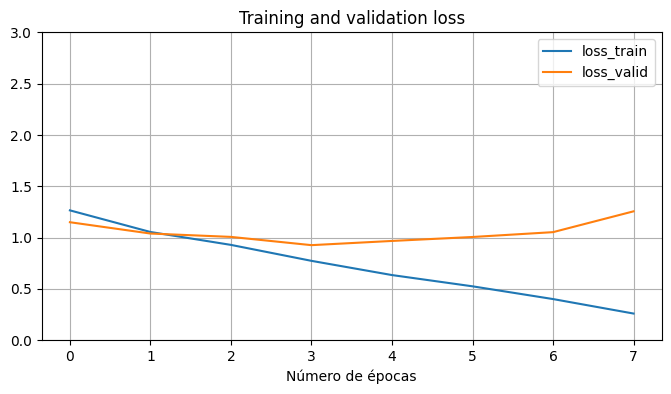

In [ ]:
# Mostramos gráficamente los valores de loss_train y loss_valid

pd.DataFrame({'loss_train': history.history['loss'],
              'loss_valid': history.history['val_loss']}).plot(figsize = (8, 4))

plt.grid(True)
plt.ylim(0, 3)
plt.xlabel('Número de épocas')
plt.title('Training and validation loss');

Lo que vemos es un claro ejemplo de Sobreajuste a partir de la época 2 ya que, si nos fijamos, podemos apreciar como la curva de pérdida en la validación aumenta mientras que la de entrenamiento baja. Esto es un indicador de Sobreajuste y lo que implica es que el modelo esta memorizando las fotos de entrenamiento y por tanto se comporta peor con las de validación.

# d) Modelo 2: reducción del overfitting (objetivo: accuracy_valid > 70%)

Introduzca en el modelo anterior las dos técnicas más habituales de reducción del overfitting:

    * drop-out
    * data augmentation

El objetivo es alcanzar un **objetivo es conseguir un accuracy sobre el conjunto de validacion > 70%.**

**Explica en qué consisten y qué utilidad tienen para nuestro problema**

In [ ]:
# Definimos nuestro nuevo modelo aplicando Dropout

model_Overfit = Sequential([

    # dimension = (150, 150, 3)
    Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same', activation = 'relu', input_shape = (150, 150, 3), name='Conv_1'),
    # dimension = ((input_shape - 1)/(stride)) + 1,((input_shape - 1)/(stride)) + 1, filters = (150, 150, 32)

    Dropout(0.45),

    MaxPooling2D(strides = (2, 2), pool_size = (2, 2), name = 'Pool_1'),
    # dimension = ((input_shape - 1)/(stride)) + 1, ((input_shape - 1)/(stride)) + 1, filters = (75, 75, 32)

    Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'Conv_2'),
    # dimension = ((input_shape - 1)/(stride)) + 1, ((input_shape - 1)/(stride)) + 1, filters = (75, 75, 64)

    Dropout(0.45),

    MaxPooling2D(strides = (2, 2), pool_size = (2, 2), name = 'Pool_2'),
    # dimension = ((input_shape-1)/(stride))+1,((input_shape-1)/(stride))+1, filters = (37, 37, 64)

    Conv2D(filters = 96, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'Conv_3'),
    # dimension = ((input_shape - 1)/(stride)) + 1, ((input_shape - 1)/(stride)) + 1, filters = (37, 37, 96)

    Dropout(0.45),

    MaxPooling2D(strides = (2,2), pool_size = (2, 2), name = 'Pool_3'),
    # dimension = ((input_shape - 1)/(stride)) + 1, ((input_shape - 1)/(stride)) + 1, filters = (18, 18, 96)

    # Hacemos la transformacion para poder trabajar con capas densas
    Flatten(),
    # dimension = (18 * 18 * 96) = (31104)

    Dense(units = 512, activation = 'relu', name = 'densa_1'),
    # dimension = (units) = (512)

    Dense(5, activation='softmax')
])

In [ ]:
# Inicializamos los nuevos generadores que aplican Data Augmentation

train_datagen_Overfit = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    width_shift_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,)

val_datagen_Overfit = ImageDataGenerator(rescale = 1./255)


In [ ]:
# Definimos nuestros nuevos Data Generators

train_generator_Overfit = train_datagen_Overfit.flow_from_directory(train_dir,
                                                                    batch_size = 100,
                                                                    target_size = (150, 150),
                                                                    class_mode = 'sparse')

val_generator_Overfit = val_datagen_Overfit.flow_from_directory(val_dir,
                                                                batch_size = 100,
                                                                target_size = (150, 150),
                                                                class_mode = 'sparse')

Found 2935 images belonging to 5 classes.
Found 735 images belonging to 5 classes.


In [ ]:
# Definimos la función de loss y el optimizador

model_Overfit.compile(
            loss = tf.keras.losses.SparseCategoricalCrossentropy(),
            optimizer = 'adam',
            metrics = ['accuracy'])

In [ ]:
# Aplicamos EarlyStopping con paciencia 4

es_callback = keras.callbacks.EarlyStopping(patience = 4, restore_best_weights = True)

# Realizamos el entrenamiento del modelo

history_Overfit = model_Overfit.fit(train_generator_Overfit,
                   epochs = 100,
                   batch_size = 100,
                   validation_data = val_generator_Overfit,
                   callbacks = [es_callback])

Epoch 1/100
30/30 [==============================] - 32s 1s/step - loss: 0.9904 - accuracy: 0.6027 - val_loss: 1.2114 - val_accuracy: 0.6027
Epoch 2/100
30/30 [==============================] - 26s 874ms/step - loss: 0.9207 - accuracy: 0.6296 - val_loss: 1.1693 - val_accuracy: 0.6150
Epoch 3/100
30/30 [==============================] - 26s 883ms/step - loss: 0.8517 - accuracy: 0.6620 - val_loss: 1.1147 - val_accuracy: 0.6150
Epoch 4/100
30/30 [==============================] - 26s 877ms/step - loss: 0.8380 - accuracy: 0.6756 - val_loss: 1.1144 - val_accuracy: 0.6490
Epoch 5/100
30/30 [==============================] - 26s 876ms/step - loss: 0.8029 - accuracy: 0.6848 - val_loss: 1.1229 - val_accuracy: 0.6354
Epoch 6/100
30/30 [==============================] - 26s 878ms/step - loss: 0.7803 - accuracy: 0.6961 - val_loss: 1.0525 - val_accuracy: 0.6449
Epoch 7/100
30/30 [==============================] - 27s 889ms/step - loss: 0.7405 - accuracy: 0.7199 - val_loss: 1.0101 - val_accuracy: 0.

__Explica qué tipos de augmentation vas a considerar y qué utilidad tienen en nuestro problema de clasificacion__

    * A partir de nuestro conjunto original de train, vamos a construir un nuevo conjunto de datos sintéticos.
      De manera que, con modificaciones sobre los datos originales, generamos nuevas muestras con las que expandir el conjunto de train.
      El efecto que conseguimos es dificultar al modelo el memorizar el conjunto de train. En nustro caso aplicaremos lo siguiente:

      -Hacemos una pequeña rotación de la imagen (20)
      -Hacemos zoom(0.2)
      -Cambiamos la anchura (0.2)
      -Giramos horizontalmente la imagen

    Con todo esto lo que buscamos es que a nuestro modelo le cueste más memorizar las imagenes.
    Es importante recalcar que el Data Augmentation se aplica solo al conjunto de train, nunca al de validación.

__Explica qué Dropout y qué utilidad tienen en nuestro problema de clasificacion__

    * Consiste en "apagar" neuronas de la capa a la que le apliquemos el DropOut.
      El número de neuronas que apagamos viene dado por el parámetro: drop rate, que suele estar en el orden del 50% para CNNs.
      Las neuronas que son apagadas, cambian de un minibatch al siguiente.
      Esto se hace para evitar el Sobreajuste, ya que si el modelo es capaz de entrenar y clasificar con un porcentaje de neuronas apagadas
      será porque de verdad está aprendiendo y no memorizando.

      En nuestro caso hemos decidido poner un Dropout bastante genérico después de las capas Convolucionales (0.45)

Muestra la evolucion de la funcion de error durante el entrenamiento. __Explica qué diferencias de comportamiento hay entre las gráficas del modelo a) y las del modelo b)__

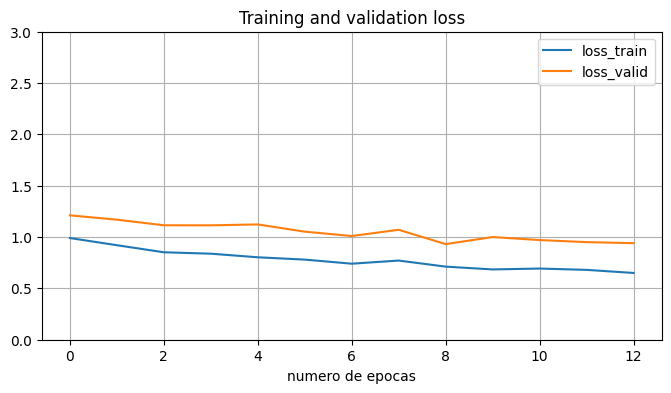

In [ ]:
# Mostramos gráficamente los valores de loss_train y loss_valid

pd.DataFrame({'loss_train': history_Overfit.history['loss'],
              'loss_valid': history_Overfit.history['val_loss']}).plot(figsize = (8,4))

plt.grid(True)
plt.ylim(0, 3)
plt.xlabel('numero de epocas')
plt.title('Training and validation loss');

Como podemos observar ambas curvas crecen y decrecen de manera paralela. A diferencia de la gráfica del anterior modelo donde claramente veíamos como empeoraba con la validación y mejoraba con el conjunto de entrenamiento. Con esta tabla podemos ver como no se está produciendo Sobreajuste.

# c) Modelo 3: Transfer Learning (objetivo: accuracy_valid > 88%)

En nuestro problema de clasificación de flores, el utilizar CNNs diseñadas y entrenadas por nosotros mismos, aparece una barrera en las proximidades del 75-80% de precisión del modelo (siempre sobre validación).

Para superar este escollo, el siguiente paso natural es la utilización de modelos preentrenados. Existe una gran variedad de ellos basados en redes CNNs clásicas, donde la principal diferencia es que acumulan más capas que nuestros modelos 1 y 2. Adicionalmente, en estos modelos se han ido incorporando diferentes propuestas para mejorar la arquitectura de la CNN.

En general, utilizando estos modelos convolucionales preentrenados podemos alcanzar accuracies próximos al 90%. Normalmente, estos modelos han sido previamente entrenados sobre datasets de gran tamaño y con gran número de categorías. P.e. en subconjuntos de Imagenet (14 millones de imagenes de 22K categorías).

Dado que estos modelos se entrenaron para resolver un problema "relativamente" parecido a nuestro problema de clasificación, parece razonable pensar que podemos aprovechar ese conocimiento capturado en la red para resolver nuestro problema de clasificación de flores.

Se pide que implemente y entrene un modelo utilizando una de estas redes pre-entrenadas (__con el objetivo de alcanzar un accuracy (sobre el conjunto de validación > 88%__). Los pasos que debe seguir son:

1.   Importa el modelo desde Tensorflow.
2.   Dado que este modelo ha sido entrenado para clasificar entre 1.000 categorías, las capas densas finales del modelo no son útiles para nuestro problema de clasificación de 5 categorías (es lo que suele llamarse include_top = SI/NO). De manera que eliminamos lo que a veces se suele llamar el "top model". De este modo sólo nos quedamos con la parte que hace la funcionalidad de "procesamiento" de la imagen.
3.   Añadimos una capa de flatten y tres nuevas capas densas especificas para nuestro problema con dimensiones 4096, 1072 y la que necesite la capa de salida (con sus correspondientes drop-out).
4.   Después haremos el denominado `Fine-Tuning` del modelo. Para ello le indicaremos a Tensorflow que únicamente debe entrenar:
   * Las dos últimas capas convolucinoales de la red preentrenada
   * Las tres capas densas que hemos incluido nuevas.

  De esta forma, quedan congeladas (no se entrenan los pesos) todas las capas convolucionales de la red preentrenada, excepto las dos últimas. Para estados dos últimas capas convolucionales, usando como punto de partida los del pre-trained model obtendremos un ajuste fino de sus pesos. Por supuesto, tensorflow entrenará no solo estas dos ultimas capas convolucionales, sino también las tres capas densas que hemos añadido.

5. Dado que estamos reutilizando un modelo que no "es nuestro", deberemos ceñirnos al tamaño de imagen que permite la red a la entrada.

Para elegir el modelo preentrenado que debe utilizar cada grupo, proceda del siguiente modo:
* Paso 1: sume los DNIs de los componentes del grupo (si el grupo tiene un sólo miembro, vaya directamente al paso 2). res = dni_1 + dn_2
* Paso 2: Aplique la siguiente operación al resultado anterior: res mod 6.
* Paso 3: Tome el modelo cuyo número asociado coincide con el resultado de la operación anterior.
* Paso 4: El porcentaje que aparece entre paréntesis junto al nombre del modelo es el accuracy (en validación) que deberías poder alcanzar sin dificultad utilizando el modelo. En todos los casos considera un input_shape = (224, 224, 3).

  0. Resnet50 (>90%)
  https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/ResNet50

  1. Resnet101 (>90%) input_shape = (224, 224, 3)
  https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet/ResNet101

  2. VGG16 (>90%) input_shape = (224, 224, 3)
  https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16/VGG16

  3. VGG19 (>90%) input_shape = (224, 224, 3) https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg19/VGG19

  4. Xception (>88%) input_shape = (224, 224, 3) https://www.tensorflow.org/api_docs/python/tf/keras/applications/xception/Xception

  5. Inceptionv3 (>88%) input_shape = (224, 224, 3) https://www.tensorflow.org/api_docs/python/tf/keras/applications/inception_v3/InceptionV3

P.e. si los DNIs de los alumnos son: 12345678 y 23456781. La suma es 35802467. De donde 35802467 mod 6 = 5. Por tanto, tomaríamos el modelo Inceptionv3.

In [ ]:
# Calculamos que modelo debemos escoger

res = 77861827 + 54187000
res = res % 6
print(res)

# Como vemos nos ha salido el modelo 5, que es InceptionV3

5


In [ ]:
# Importamos el modelo que nos ha salido, cambiamos el include_top a False tal y como dice el enunciado.
# Además modificamos el input_shape y las clases a las correspondientes.
x = tf.keras.applications.inception_v3.InceptionV3(
    include_top = False,
    weights = 'imagenet',
    input_shape = (224, 224, 3),
    classes = 5,
    classifier_activation = 'softmax')

# Veamos como es el modelo con el metodo summary
print(x.summary())


87910968/87910968 [==============================] - 0s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)           

In [ ]:
# Creamos una función que nos hará las funciones de fine uning con el modelo preentrenado InceptionV3
def crea_modelo(input_shape, clases, fine_tune = 0):

    # Importamos el modelo que nos ha salido, cambiamos el include_top a False tal y como dicce el enunciado.
    # Además modificamos el input_shape y las clases a las correspondientes.
    conv_base = tf.keras.applications.inception_v3.InceptionV3(
                                                include_top = False,
                                                weights = 'imagenet',
                                                input_shape = input_shape,
                                                classes = clases,
                                                classifier_activation = 'softmax')

    # Ponemos las dos últimas capas convolucionales que sean entreanables e indicamos al resto que no lo sean
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False;
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Creamos un nuevo 'top' del modelo añadiéndole las capas densas indicadas en el enunciado y el dropout
    # Esto lo hacemos con un 'bootstrapping' del nuevo modelo a las capas del modelo preentrenado.

    # Para ello cogemos las capas preentrenadas
    top_model = conv_base.output

    # Le añadimos las densas y el dropout
    top_model = Flatten(name = "flatten")(top_model)
    top_model = Dense(units = 4096, activation = 'relu', name = 'densa_1')(top_model)
    top_model = Dropout(0.5)(top_model)
    top_model = Dense(units = 1072, activation = 'relu', name = 'densa_2')(top_model)
    top_model = Dropout(0.5)(top_model)
    output_layer = Dense(clases, activation = 'softmax')(top_model)

    # Agrupamos el modelo preentrenado en un uno nuevo conectado con las ultimas capas utilziando el objeto 'Model' de keras
    model = Model(inputs = conv_base.input, outputs = output_layer)

    return model




6.   Una vez definido el modelo tenemos que crear los data_generators asociados. Para ello:
> * Utiliza Data augmentation.
> * Las imágenes tienen que ser preprocesadas igual que cuando se entrenó el modelo VGG original. Para ello se utiliza el parámetro `preprocessing_function=preprocess_input` (preprocess_input importado desde `keras.applications.vgg16` en ambos generators (train y valid). Por tanto, no hay que indicarle `rescale`. En caso de ser necesario, se encargará `preprocess_input`.
> * Recuerda que el tamaño de imagen debe ser: 224x224.




In [ ]:
# Creamos el modelo y hacemos llamada a la función con los parámetros dados en el enunciado
model_Transfer = crea_modelo((224, 224, 3), 5, 2)


In [ ]:
from keras.applications.inception_v3 import preprocess_input;

# Hemos añadido el mismo DataAugmentation del anterior modelo,
# hemos quitado el rescale y añadido el preprocessing function correspondiente
train_datagen_Transfer = ImageDataGenerator(
    preprocessing_function = preprocess_input,
    rotation_range = 20,
    width_shift_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,)

# Quitamos el rescale y añadimos el parametro preprocessing function
val_datagen_Transfert = ImageDataGenerator( preprocessing_function = preprocess_input)

In [ ]:
# Ambos generadores se quedan igual que los anteriores, lo único que modificamos es el target_size
train_generator_Transfer = train_datagen_Transfer.flow_from_directory(train_dir,
                                                                    batch_size = 100,
                                                                    target_size = (224, 224),
                                                                    class_mode = 'sparse')

val_generator_Transfer = val_datagen_Transfert.flow_from_directory(val_dir,
                                                                batch_size = 100,
                                                                target_size = (224, 224),
                                                                class_mode = 'sparse')

Found 2935 images belonging to 5 classes.
Found 735 images belonging to 5 classes.



7.   A la hora de entrenar un modelo pretrained es típico bajar el learning rate respecto al que utilizaríamos para un modelo nuestro desde cero.

In [ ]:
# Bajamos el learning rate de 0.001 (por defecto) a 0.0009
model_Transfer.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(0.0009),
    metrics = ['accuracy'])

In [ ]:
# Aplicamos EarlyStopping con paciencia 4

es_callback = keras.callbacks.EarlyStopping(patience = 4, restore_best_weights = True)

# Realizamos el entrenamiento del modelo

history_Transfer = model_Transfer.fit(train_generator_Transfer,
                   epochs = 100,
                   batch_size = 100,
                   validation_data = val_generator_Transfer,
                   callbacks = [es_callback])

Epoch 1/100
30/30 [==============================] - 84s 2s/step - loss: 21.0796 - accuracy: 0.4545 - val_loss: 0.6866 - val_accuracy: 0.7701
Epoch 2/100
30/30 [==============================] - 46s 2s/step - loss: 1.3060 - accuracy: 0.6269 - val_loss: 0.8220 - val_accuracy: 0.7687
Epoch 3/100
30/30 [==============================] - 48s 2s/step - loss: 0.8973 - accuracy: 0.6879 - val_loss: 0.6823 - val_accuracy: 0.7905
Epoch 4/100
30/30 [==============================] - 49s 2s/step - loss: 0.7463 - accuracy: 0.7339 - val_loss: 0.5831 - val_accuracy: 0.8136
Epoch 5/100
30/30 [==============================] - 47s 2s/step - loss: 0.6911 - accuracy: 0.7533 - val_loss: 0.5024 - val_accuracy: 0.8299
Epoch 6/100
30/30 [==============================] - 48s 2s/step - loss: 0.6242 - accuracy: 0.7714 - val_loss: 0.4496 - val_accuracy: 0.8599
Epoch 7/100
30/30 [==============================] - 49s 2s/step - loss: 0.6379 - accuracy: 0.7840 - val_loss: 0.4446 - val_accuracy: 0.8585
Epoch 8/100


**Investiga cómo es la estructura del modelo preentrenado que has utilizado. Descríbelo**

Inception v3 es un modelo de reconocimiento de imágenes.

El modelo está formado por bloques de compilación simétricos y asimétricos, que incluyen convoluciones, AvgPool, MaxPool, concatenaciones, DropOut y capas completamente conectadas. Tenemos una única entrada de 299x299x3 y dos salidas, una intermedia y otra final, de 8x8x2048, aunque únicamente devolveremos la última de ellas adaptada a nuestro modelo ajustado. Como podemos observar, se distinguen 5 bloques de capas diferentes. Sigue una arquitectura tal que se define una repetición del primer bloque de capas tres veces, añade un segundo bloque diferente a los anteriores, seguido de un bloque que se repite posteriormente 4 veces. Luego añade un cuarto bloque distinto y un quinto bloque que se repite dos veces antes de pasar por la capa de salida. La normalización por lotes se usa ampliamente en todo el modelo y se aplica a las entradas de activación. La pérdida se calcula con softmax.

En la siguiente captura de pantalla, se muestra un diagrama de alto nivel del modelo:

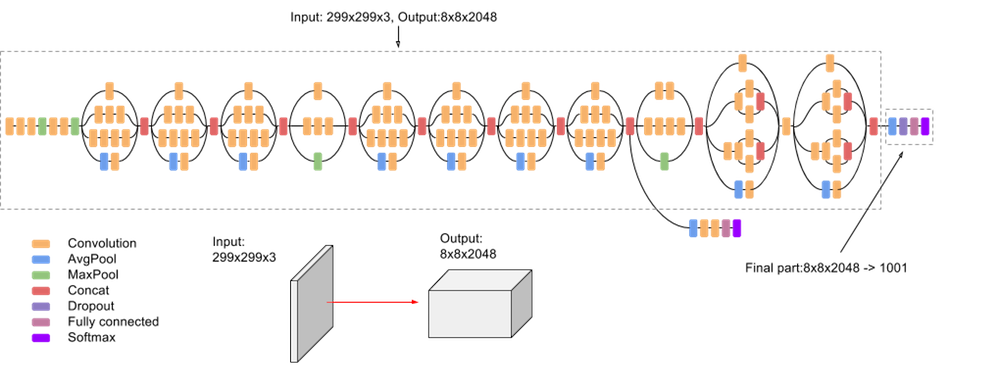